#### Imports

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

#### Load data

In [13]:
# load data
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

#### Define variables

In [14]:
n_iterations = 5 #100  # for hyperparmeter tuning
cv_folds = 5           # number of cross validation folds for hyperparameter 

n_estimator_min = 100
n_estimator_max = 401 #1001
n_estimator_step = 100

max_depth_min = 5
max_depth_max = 21 #31
max_depth_step = 5

sample_leaf_split_values = [2,5,10]

min_samples_leaf_values = [1,2,4]

max_features_values = [None, 'sqrt', 'log2']

bootstrap_values = [True, False]

#### Search grid and RF definition

In [ ]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)

# Hyperparameter grid
param_dist = {
    'n_estimators': np.arange(n_estimator_min, n_estimator_max, n_estimator_step),
    'max_depth': [None] + list(np.arange(max_depth_min, max_depth_max, max_depth_step)),
    'min_samples_split': sample_leaf_split_values,
    'min_samples_leaf': min_samples_leaf_values,
    'max_features': max_features_values,
    'bootstrap': bootstrap_values
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=1)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=n_iterations,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=1
)

#### Train model

In [16]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

#### Results

Best hyperparameters: {'n_estimators': np.int64(400), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Accuracy: 0.9188777905489631
AUROC: 0.8149061629296228
Confusion Matrix:
 [[56550   227]
 [ 4784   210]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56777
           1       0.48      0.04      0.08      4994

    accuracy                           0.92     61771
   macro avg       0.70      0.52      0.52     61771
weighted avg       0.89      0.92      0.89     61771



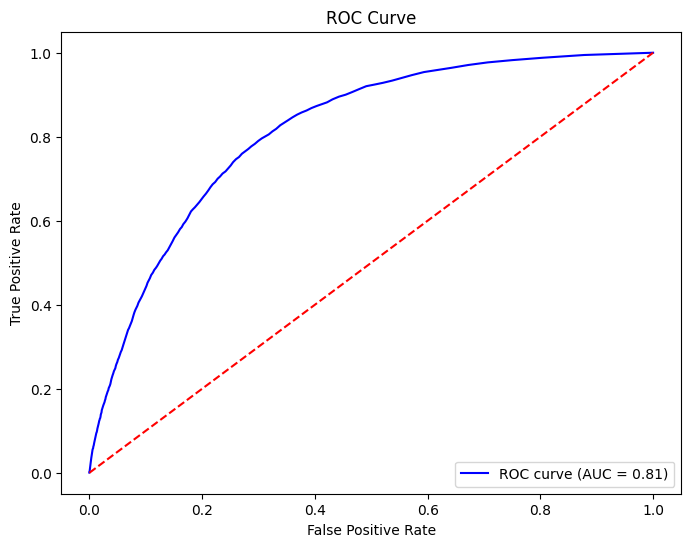

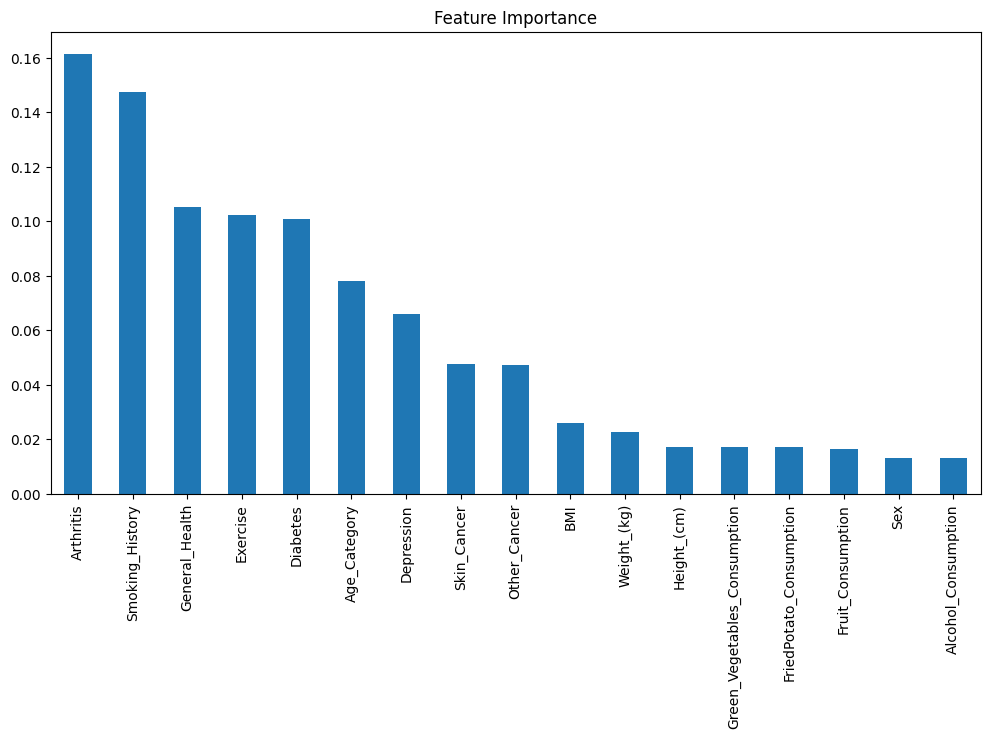

In [ ]:
# Best parameters
print("Best hyperparameters:", random_search.best_params_)

# Best estimator
best_rf = random_search.best_estimator_

# Evaluate model
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print("AUROC:", auroc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report (precision, recall, F1)
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title('Feature Importance')
plt.show()